In [2]:
import numpy as np

"""https://stackoverflow.com/questions/32655686/histogram-matching-of-two-images-in-python-2-x"""
def hist_match(source, template):
    """
    Adjust the pixel values of a grayscale image such that its histogram
    matches that of a target image

    Arguments:
    -----------
        source: np.ndarray
            Image to transform; the histogram is computed over the flattened
            array
        template: np.ndarray
            Template image; can have different dimensions to source
    Returns:
    -----------
        matched: np.ndarray
            The transformed output image
    """

    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()

    # get the set of unique pixel values and their corresponding indices and
    # counts
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
                                            return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    # interpolate linearly to find the pixel values in the template image
    # that correspond most closely to the quantiles in the source image
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

    return interp_t_values[bin_idx].reshape(oldshape)

type: uint8
type: (100, 100, 3)
type: 95
type: 255


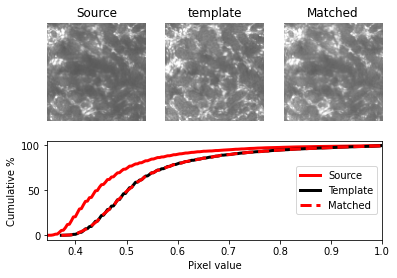

In [3]:
from matplotlib import pyplot as plt
#from scipy.misc import lena, ascent
from PIL import Image
from numpy import asarray

source = asarray(Image.open('1.jpg'))/255.0
template = asarray(Image.open('2.jpg'))/255.0
matched = hist_match(source, template)

def ecdf(x):
    """convenience function for computing the empirical CDF"""
    vals, counts = np.unique(x, return_counts=True)
    ecdf = np.cumsum(counts).astype(np.float64)
    ecdf /= ecdf[-1]
    return vals, ecdf

x1, y1 = ecdf(source.ravel())
x2, y2 = ecdf(template.ravel())
x3, y3 = ecdf(matched.ravel())

fig = plt.figure()
plt.rcParams["figure.figsize"] = (20, 20) # (w, h)
gs = plt.GridSpec(2, 3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharex=ax1, sharey=ax1)
ax3 = fig.add_subplot(gs[0, 2], sharex=ax1, sharey=ax1)
ax4 = fig.add_subplot(gs[1, :])
for aa in (ax1, ax2, ax3):
    aa.set_axis_off()
    
    
    
matched = (matched*255).astype(np.uint8)
im = Image.fromarray(matched)
im.save("matched.jpg")

ax1.imshow(source, cmap=plt.cm.gray)
ax1.set_title('Source')
ax2.imshow(template, cmap=plt.cm.gray)
ax2.set_title('template')
ax3.imshow(matched, cmap=plt.cm.gray)
ax3.set_title('Matched')


print("type:",matched.dtype)
print("type:",matched.shape)
print("type:",np.amin(matched))
print("type:",np.amax(matched))


ax4.plot(x1, y1 * 100, '-r', lw=3, label='Source')
ax4.plot(x2, y2 * 100, '-k', lw=3, label='Template')
ax4.plot(x3, y3 * 100, '--r', lw=3, label='Matched')
ax4.set_xlim(x1[0], x1[-1])
ax4.set_xlabel('Pixel value')
ax4.set_ylabel('Cumulative %')
ax4.legend(loc=5)

0.0027598978023205545


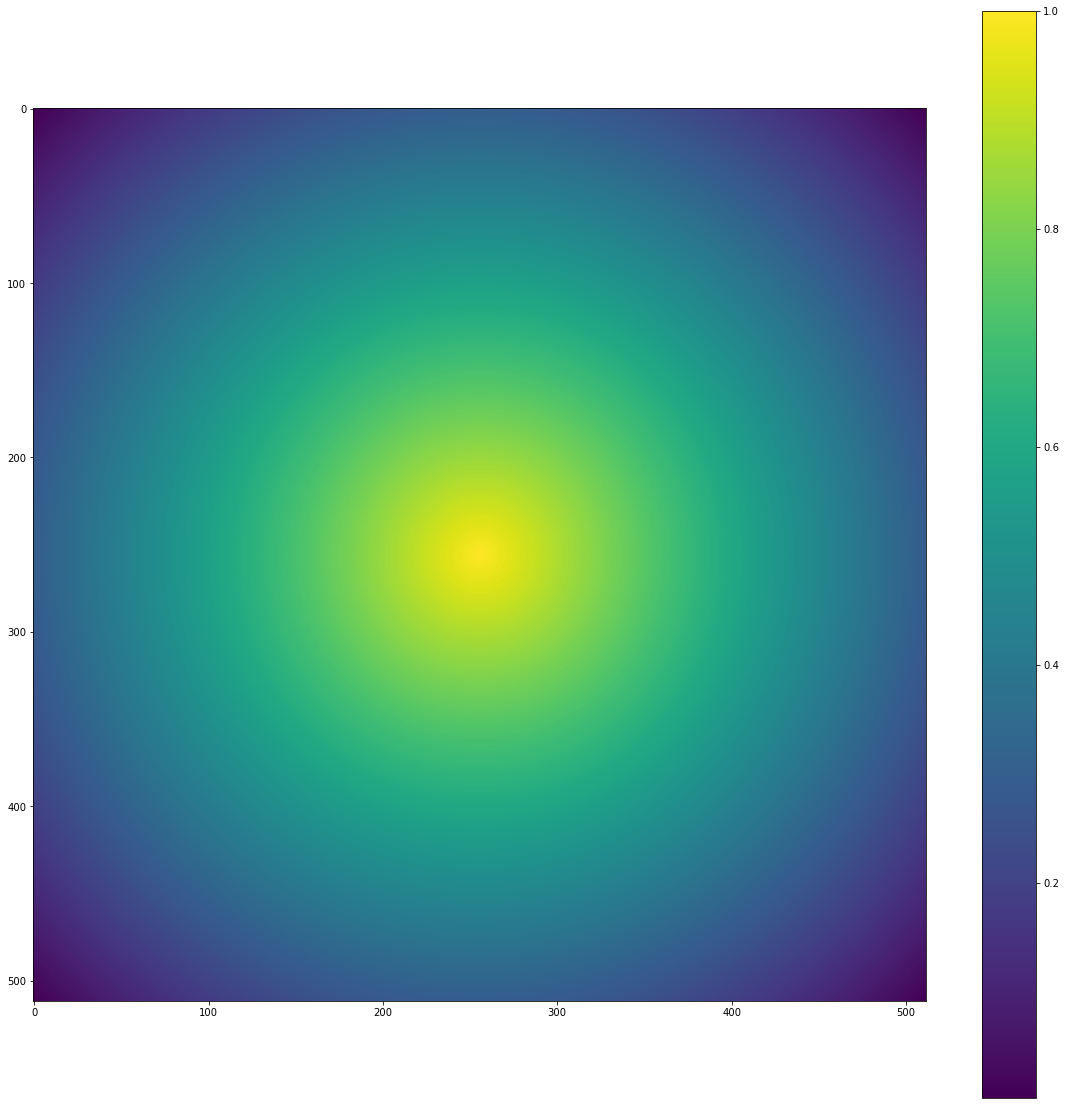

In [4]:
from scipy.ndimage.morphology import distance_transform_edt
import numpy as np
from matplotlib import pyplot as plt

weights = np.ones((512,512))
weights[256,256] = 0
weights[255,256] = 0
weights[256,255] = 0
weights[256,255] = 0
distance_map = distance_transform_edt(weights)
max_value = np.amax(distance_map)
distance_map = distance_map / (max_value+1)
distance_map = (1-distance_map)

print(np.min(distance_map))

plt.imshow(distance_map, interpolation='nearest')
plt.rcParams["figure.figsize"] = (10, 10) # (w, h)
plt.colorbar();
plt.show()

(50, 50)


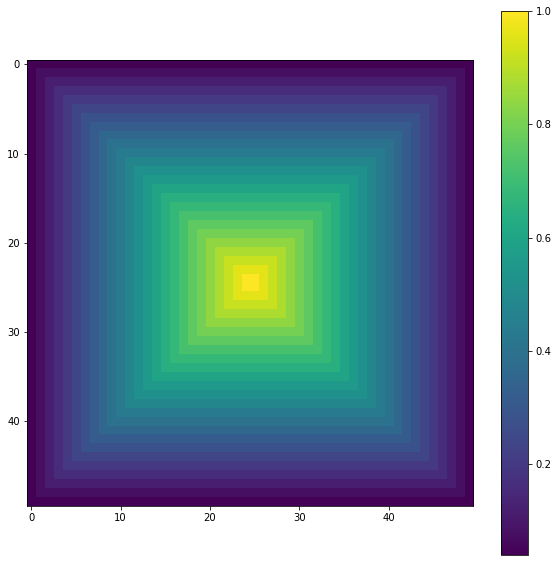

In [5]:
from scipy.ndimage.morphology import distance_transform_edt


#weights = np.ones((50,50))
#weights[25,25] = 0
#weights[24,25] = 0
#weights[25,24] = 0
#weights[24,24] = 0
#distance_map = distance_transform_edt(weights)
#max_value = np.amax(distance_map)
#distance_map = distance_map / max_value
#distance_map = 1-distance_map
tile_size = 50
step_size = int(tile_size / 2)

weights = np.ones((tile_size+2,tile_size+2))
weights[:,0] = 0
weights[:,tile_size+1] = 0
weights[0,:] = 0
weights[tile_size+1,:] = 0

distance_map = distance_transform_edt(weights)[1:tile_size+1,1:tile_size+1]
print(distance_map.shape)

max_value = np.amax(distance_map)
distance_map = distance_map / max_value

just_ones = np.ones((tile_size,tile_size)).astype(np.float)

plt.imshow(distance_map, interpolation='nearest')
plt.rcParams["figure.figsize"] = (10, 10) # (w, h)
plt.colorbar();
plt.show()


In [6]:

def ad_hist_match(volume, overall_nr_of_neighbors = 2, tile_size = 50, step_size = 25):

    #tile_size = 50
    #step_size = int(tile_size / 2)

    weights = np.ones((tile_size+2,tile_size+2))
    weights[:,0] = 0
    weights[:,tile_size+1] = 0
    weights[0,:] = 0
    weights[tile_size+1,:] = 0

    distance_map = distance_transform_edt(weights)[1:tile_size+1,1:tile_size+1]
    print(distance_map.shape)

    max_value = np.amax(distance_map)
    distance_map = distance_map / max_value
    

    volume_out = np.zeros(volume.shape)
    weights_out = np.zeros(volume.shape)

    volume_out[0,:,:] = volume[0,:,:]
    volume_out[volume.shape[0]-1,:,:] = volume[volume.shape[0]-1,:,:]
    
    weights_out[0,:,:] = np.ones((volume.shape[1],volume.shape[2])).astype(np.float)
    weights_out[volume.shape[0]-1,:,:] = np.ones((volume.shape[1],volume.shape[2])).astype(np.float)

    for i in range(1, volume.shape[0]-1):
        print('{}/{}'.format(i,volume.shape[0]-1))
        tiles_j = int(np.floor(volume.shape[1]/float(tile_size/2.0)))-1
        tiles_k = int(np.floor(volume.shape[2]/float(tile_size/2.0)))-1

        for j in range(0, tiles_j):
            for k in range(0, tiles_k):
                #source = volume[i,j*tile_size:(j+1)*tile_size,k*tile_size:(k+1)*tile_size]
                source = volume[i,j*step_size:j*step_size+tile_size,k*step_size:k*step_size+tile_size]
                template = np.array([])

                nr_of_neighbors = 0
                for l in range(1, overall_nr_of_neighbors+1):
                    if i >= l and i < volume.shape[0]-l:
                        nr_of_neighbors = l

                for l in range(1, nr_of_neighbors+1):
                    template_new = volume[i-l,j*step_size:j*step_size+tile_size,k*step_size:k*step_size+tile_size]
                    template = np.concatenate((template, template_new), axis=1) if template.size else template_new
                    template_new = volume[i+l,j*step_size:j*step_size+tile_size,k*step_size:k*step_size+tile_size]
                    template = np.concatenate((template, template_new), axis=1) if template.size else template_new

                matched = hist_match(source, template)
                volume_out[i,j*step_size:j*step_size+tile_size,k*step_size:k*step_size+tile_size] = volume_out[i,j*step_size:j*step_size+tile_size,k*step_size:k*step_size+tile_size] + (matched * distance_map)
                weights_out[i,j*step_size:j*step_size+tile_size,k*step_size:k*step_size+tile_size] = weights_out[i,j*step_size:j*step_size+tile_size,k*step_size:k*step_size+tile_size] + distance_map



        for j in range(0, tiles_j):
            source = volume[i,j*step_size:j*step_size+tile_size,volume.shape[2]-tile_size:volume.shape[2]]
            template = np.array([])

            nr_of_neighbors = 0
            for l in range(1, overall_nr_of_neighbors+1):
                if i >= l and i < volume.shape[0]-l:
                    nr_of_neighbors = l

            for l in range(1, nr_of_neighbors+1):
                template_new = volume[i-l,j*step_size:j*step_size+tile_size,volume.shape[2]-tile_size:volume.shape[2]]
                template = np.concatenate((template, template_new), axis=1) if template.size else template_new
                template_new = volume[i+l,j*step_size:j*step_size+tile_size,volume.shape[2]-tile_size:volume.shape[2]]
                template = np.concatenate((template, template_new), axis=1) if template.size else template_new

            matched = hist_match(source, template)
            volume_out[i,j*step_size:j*step_size+tile_size,volume.shape[2]-tile_size:volume.shape[2]] = volume_out[i,j*step_size:j*step_size+tile_size,volume.shape[2]-tile_size:volume.shape[2]] + (matched * distance_map)
            weights_out[i,j*step_size:j*step_size+tile_size,volume.shape[2]-tile_size:volume.shape[2]] = weights_out[i,j*step_size:j*step_size+tile_size,volume.shape[2]-tile_size:volume.shape[2]] + distance_map


        for k in range(0, tiles_k):
            source = volume[i,volume.shape[1]-tile_size:volume.shape[1],k*step_size:k*step_size+tile_size]
            template = np.array([])

            nr_of_neighbors = 0
            for l in range(1, overall_nr_of_neighbors+1):
                if i >= l and i < volume.shape[0]-l:
                    nr_of_neighbors = l

            for l in range(1, nr_of_neighbors+1):
                template_new = volume[i-l,volume.shape[1]-tile_size:volume.shape[1],k*step_size:k*step_size+tile_size]
                template = np.concatenate((template, template_new), axis=1) if template.size else template_new
                template_new = volume[i+l,volume.shape[1]-tile_size:volume.shape[1],k*step_size:k*step_size+tile_size]
                template = np.concatenate((template, template_new), axis=1) if template.size else template_new

            matched = hist_match(source, template)
            volume_out[i,volume.shape[1]-tile_size:volume.shape[1],k*step_size:k*step_size+tile_size] = volume_out[i,volume.shape[1]-tile_size:volume.shape[1],k*step_size:k*step_size+tile_size] + (matched * distance_map)
            weights_out[i,volume.shape[1]-tile_size:volume.shape[1],k*step_size:k*step_size+tile_size] = weights_out[i,volume.shape[1]-tile_size:volume.shape[1],k*step_size:k*step_size+tile_size] + distance_map



        source = volume[i,volume.shape[1]-tile_size:volume.shape[1],volume.shape[2]-tile_size:volume.shape[2]]
        template = np.array([])

        nr_of_neighbors = 0
        for l in range(1, overall_nr_of_neighbors+1):
            if i >= l and i < volume.shape[0]-l:
                nr_of_neighbors = l

        for l in range(1, nr_of_neighbors+1):
            template_new = volume[i-l,volume.shape[1]-tile_size:volume.shape[1],volume.shape[2]-tile_size:volume.shape[2]]
            template = np.concatenate((template, template_new), axis=1) if template.size else template_new
            template_new = volume[i+l,volume.shape[1]-tile_size:volume.shape[1],volume.shape[2]-tile_size:volume.shape[2]]
            template = np.concatenate((template, template_new), axis=1) if template.size else template_new

        matched = hist_match(source, template)
        volume_out[i,volume.shape[1]-tile_size:volume.shape[1],volume.shape[2]-tile_size:volume.shape[2]] = volume_out[i,volume.shape[1]-tile_size:volume.shape[1],volume.shape[2]-tile_size:volume.shape[2]] + (matched * distance_map)
        weights_out[i,volume.shape[1]-tile_size:volume.shape[1],volume.shape[2]-tile_size:volume.shape[2]] = weights_out[i,volume.shape[1]-tile_size:volume.shape[1],volume.shape[2]-tile_size:volume.shape[2]] + distance_map


    volume_out = volume_out / weights_out
    return volume_out



In [10]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [36]:
def narrow_frequency_filter(img):
    rows, cols = img.shape
    crow,ccol = rows//2 , cols//2
    print(img.shape)
    
    
    
    dft = cv2.dft(np.float32(img),flags = cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    magnitude_spectrum = 20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))
    
    # create a mask first, center square is 1, remaining all zeros
    mask = np.zeros((rows,cols,2),np.uint8)

    size_outer = 11
    size_inner = 8

    circle = 1-create_circular_mask(img.shape[0], img.shape[1], center=(ccol, crow), radius=size_outer)
    circle = circle + create_circular_mask(img.shape[0], img.shape[1], center=(ccol, crow), radius=size_inner)
    mask[:,:,0] = circle
    mask[:,:,1] = circle

    #mask = np.ones((rows,cols,2),np.uint8)
    #mask[crow-size_outer:crow+size_outer, ccol-size_outer:ccol+size_outer] = 0
    #mask[crow-size_inner:crow+size_inner, ccol-size_inner:ccol+size_inner] = 1

    mask = np.ones((rows,cols,2),np.uint8)
    mask[crow-size_outer:crow+size_outer, ccol-size_outer:ccol+size_outer] = 0
    mask[:,:,0] = mask[:,:,0] + create_circular_mask(img.shape[0], img.shape[1], center=(ccol, crow), radius=size_inner)
    mask[:,:,1] = mask[:,:,1] + create_circular_mask(img.shape[0], img.shape[1], center=(ccol, crow), radius=size_inner)

    # apply mask and inverse DFT
    fshift = dft_shift*mask
    f_ishift = np.fft.ifftshift(fshift)
    img_back = cv2.idft(f_ishift)
    img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

    
    
    magnitude_spectrum = magnitude_spectrum * mask[:,:,0]

    print(np.min(img))

    print(np.max(img_back))

    minimum_value = np.min(img)
    maximum_value = np.max(img)
    value_range = maximum_value - minimum_value

    minimum_value_back = np.min(img_back)
    maximum_value_back = np.max(img_back)
    value_range_back = maximum_value_back - minimum_value_back

    img_back = (img_back - minimum_value_back)/value_range_back
    img_back = (img_back * maximum_value)

    #plt.subplot(131),plt.imshow(img, cmap = 'gray', vmin=0, vmax=2)
    #plt.title('Input Image'), plt.xticks([]), plt.yticks([])
    #plt.subplot(132),plt.imshow(img_back, cmap = 'gray', vmin=0, vmax=2)
    #plt.title('corrected'), plt.xticks([]), plt.yticks([])
    #plt.subplot(133),plt.imshow(magnitude_spectrum, cmap = 'gray')
    #plt.title('Masked frequency domain'), plt.xticks([]), plt.yticks([])
    #plt.show()
    
    return img_back

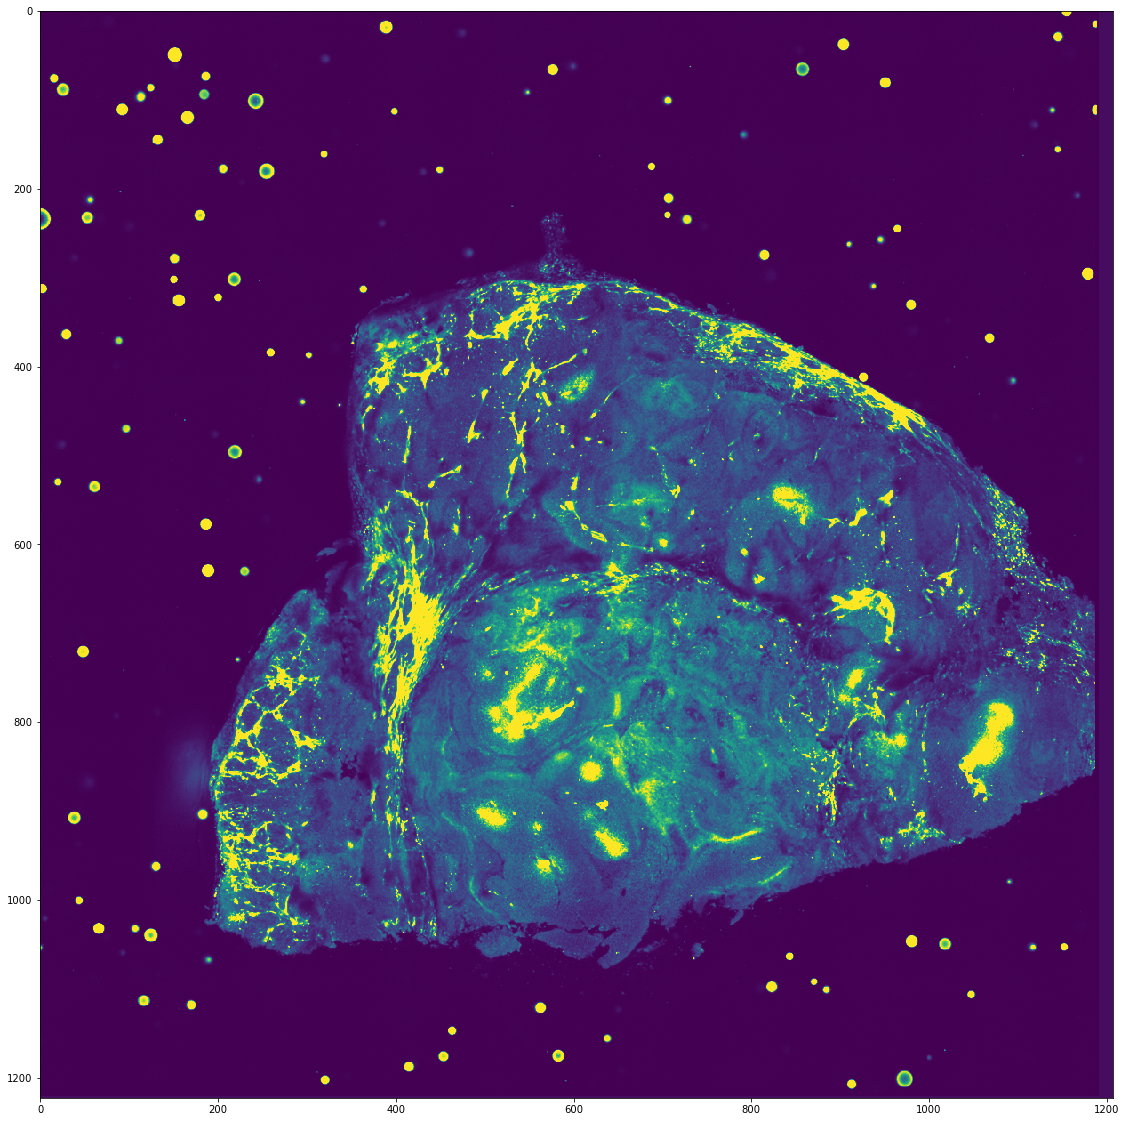

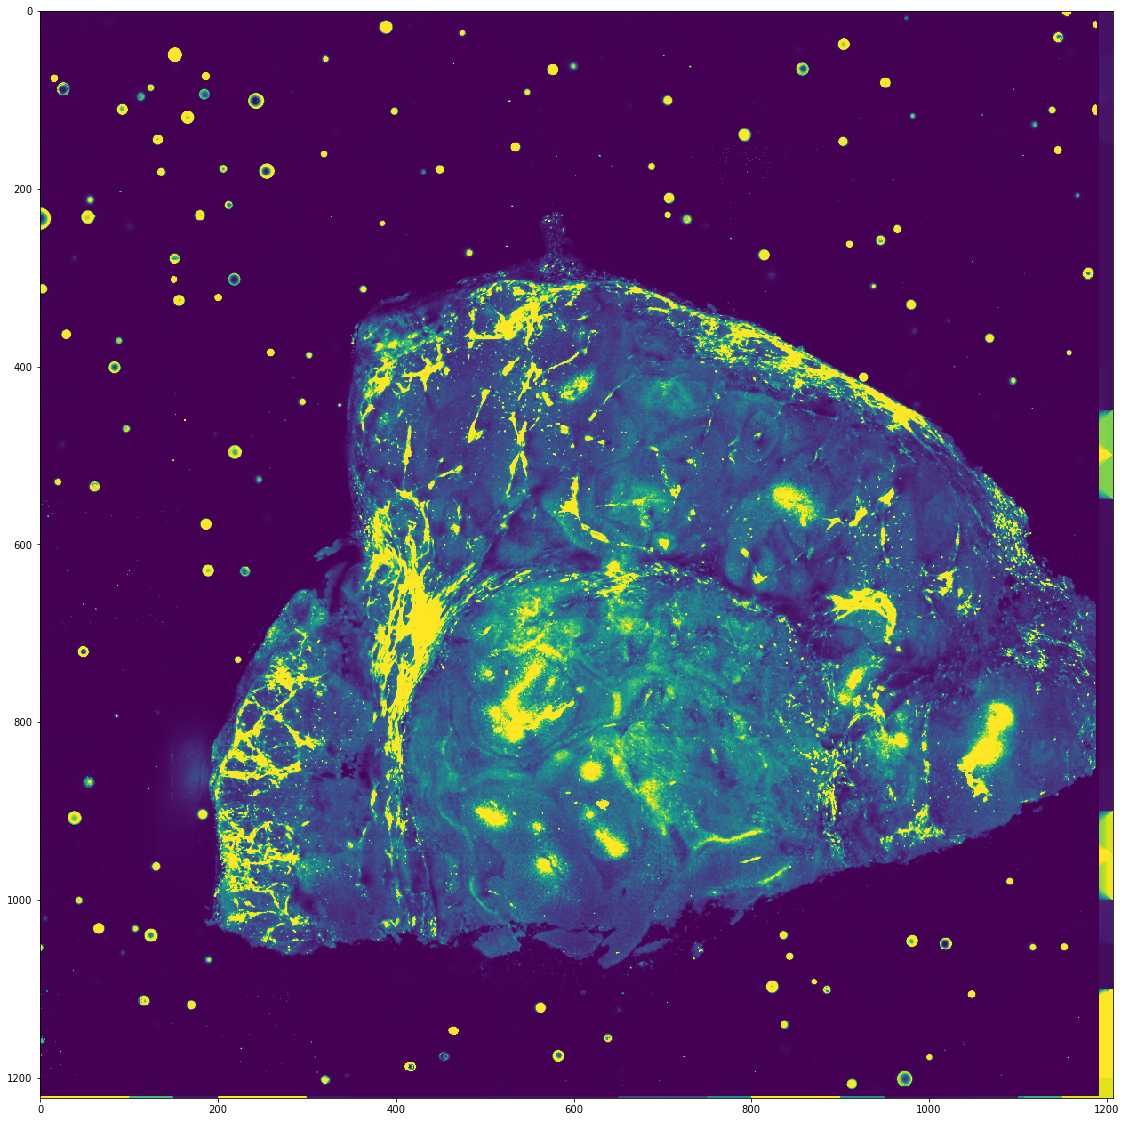

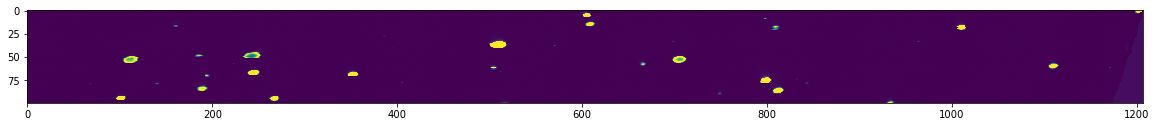

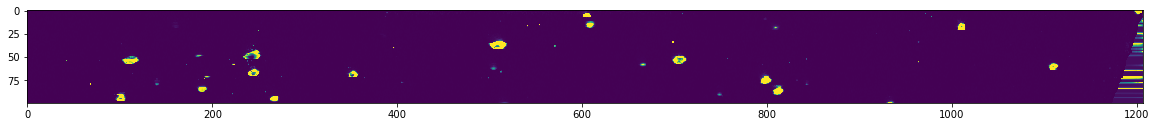

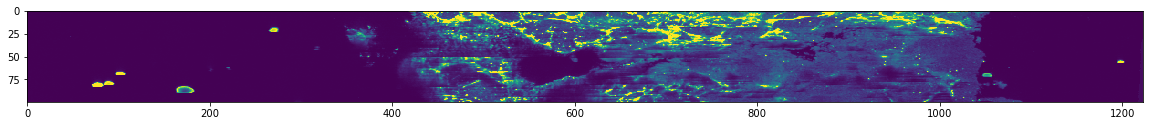

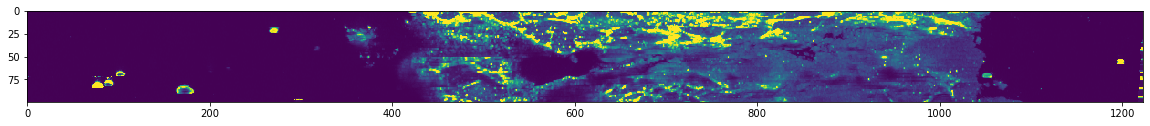

In [53]:
import SimpleITK as sitk
import scipy
from IPython.display import clear_output
from matplotlib import pyplot as plt 
%matplotlib inline


file_names2 = ['20190919_PDX_STG139645_gfp_100x15um',
            '20201109_PDX_STG1394_GFP_100x15um',
            '20190911_PDX_STG316_gfp_100x15um',
            '20190916_PDX_STG316_gfp_100x15um_set2',
            '20191021_PDX_STG143_100x15um',
            '20191209_PDX_STG143SC_50x15um',
            '20191210_PDX_STG143SC_100x15um_set2',
            '20200219_PDX_AB559_50X15um',
            '20200225_PDX_Ab559_set2_100X15um',
            '20200226_PDX_Ab580_HC_gfp_100x15um',
            '20200227_PDX_Ab580_HC_gfp_set2_100x15um',
            '20200615_PDX_AB580_GFP_100x15um_set1',
            '20200629_PDX_PAR1040_GFP_100x15um_set1',
            '20200707_PDX_PAR1040_GFP_100x15um_set2',
            '20200804_PDX_AB580SC_gfp_100x15um_set1',
            '20200817_PDX_AB764_017376_gfp_100x15um_set1',
            '20200818_PDX_PAR1006_gfp_100x15um_set1',
            '20200902_PDX_PAR1059_gfp_100x15um_set1',
            '20210105_PDX_STG316_GFP_rep1_100x15um',
            '20201207_PDX_PAR1059x2GFP_100x15um',
            '20200908_PDX_PAR1022_gfp_100x15um_set1',
            '20201103_PDX_PAR1022_GFP_Rep2_100x15um',
            '20210119_PDX_STG316_GFP_100x15um',
            '20210121_PDX_STG316_GFP_001389_100x15um',
            '20210104_PDX_AB580Sc_GFP_100x15um',
            '20201216_PDX_STG143_SC_GFP_100x15um',
            '20201109_PDX_STG1394_GFP_100x15um',
            '20201110_PDX_HC1010_GFP_100x15um',
            '20210211_PDX_PAR1006_GFP_100x15um',
            '20210127_PDX_AB630_GFP_100x15um',
            '20210126_AB764_017377_100x15um_gfp',]

#file_names = ['20201216_PDX_STG143_SC_GFP_100x15um']
#file_names = ['20190911_PDX_STG316_gfp_100x15um']
file_names = ['20200629_PDX_PAR1040_GFP_100x15um_set1']

for file_name in file_names:
    in_file_name = "volumes/"+file_name+".mha"
    out_file_name = "processed/"+file_name+".mha"
    volume_itk = sitk.ReadImage(in_file_name, imageIO="MetaImageIO")
    volume = sitk.GetArrayFromImage(volume_itk)
    
    
    volume_out = volume
        
        
    #volume_out = np.zeros(volume.shape)
    
    #volume_out[0,:,:] = volume[0,:,:]
    #volume_out[1,:,:] = volume[1,:,:]
    #volume_out[volume.shape[0]-3,:,:] = volume[volume.shape[0]-3,:,:]
    #volume_out[volume.shape[0]-2,:,:] = volume[volume.shape[0]-2,:,:]
    #volume_out[volume.shape[0]-1,:,:] = volume[volume.shape[0]-1,:,:]
    
    
    
    #for z in range(2, volume.shape[0]-3):
    #for z in range(1, volume.shape[0]-2):
        
        #volume_out[z,:,:] = volume_out[z,:,:] + 2.1 * volume[z-2,:,:]
        #volume_out[z,:,:] = volume_out[z,:,:] + 13.6 * volume[z-1,:,:]
        #volume_out[z,:,:] = volume_out[z,:,:] + 34.15 * volume[z,:,:]
        #volume_out[z,:,:] = volume_out[z,:,:] + 34.15 * volume[z+1,:,:]
        #volume_out[z,:,:] = volume_out[z,:,:] + 13.6 * volume[z+2,:,:]
        #volume_out[z,:,:] = volume_out[z,:,:] + 2.1 * volume[z+3,:,:]
        #volume_out[z,:,:] = volume_out[z,:,:] / (13.6 + 34.15 + 13.6 + 34.15 + 2.1 + 2.1)
        
        #volume_out[z,:,:] = volume_out[z,:,:] + 5.7 * volume[z-1,:,:]
        #volume_out[z,:,:] = volume_out[z,:,:] + 68.3 * volume[z,:,:]
        #volume_out[z,:,:] = volume_out[z,:,:] + 5.7 * volume[z+1,:,:]
        #volume_out[z,:,:] = volume_out[z,:,:] / (68.3 + 5.7 + 5.7)
    #for z in range(0, volume.shape[0]-1):
    #    volume_out[z,:,:] = np.mean( np.array([ volume[z, :, :], volume[z+1, :, :]]), axis=0 )
    #for z in range(0, volume.shape[1]-1):
    #    volume_out[z,:,:] = np.mean( np.array([ volume[:, z, :], volume[z+1, :, :]]), axis=0 )
    #for z in range(0, volume.shape[0]-1):
    #    volume_out[z,:,:] = np.mean( np.array([ volume[z, :, :], volume[z+1, :, :]]), axis=0 )
    
    
    volume_out = scipy.ndimage.filters.maximum_filter1d(volume_out, size=2, axis=0)
    
    
    #for z in range(0, volume.shape[0]):
    #    volume_out[z,:,:] = narrow_frequency_filter(volume[z,:,:])
        
    #kernel = np.full((2, 4, 4), 1.0/32)
    #volume_out = scipy.ndimage.filters.convolve(volume_out, kernel)
    
    volume_out = ad_hist_match(volume_out, overall_nr_of_neighbors = 3, tile_size = 100, step_size = 50)
    
    
    volume_out_itk = sitk.GetImageFromArray(volume_out)
    volume_out_itk.SetSpacing(volume_itk.GetSpacing())
    sitk.WriteImage(volume_out_itk, out_file_name)
    clear_output(wait=True)
    
    

    plt.rcParams["figure.figsize"] = (20, 20) # (w, h)
    plt.imshow(volume[int(volume_out.shape[0]/2)], interpolation='nearest')
    plt.clim(0, 5)
    plt.show()
    plt.imshow(volume_out[int(volume_out.shape[0]/2)], interpolation='nearest')
    plt.clim(0, 5)
    #plt.colorbar();
    plt.show()
    plt.rcParams["figure.figsize"] = (20, 20) # (w, h)
    plt.imshow(volume[:,100,:], interpolation='nearest')
    plt.clim(0, 5)
    plt.show()
    plt.imshow(volume_out[:,100,:], interpolation='nearest')
    plt.clim(0, 5)
    plt.show()
    plt.imshow(volume[:,:,350], interpolation='nearest')
    plt.clim(0, 5)
    plt.show()
    plt.imshow(volume_out[:,:,350], interpolation='nearest')
    plt.clim(0, 5)
    #plt.colorbar();
    plt.show()


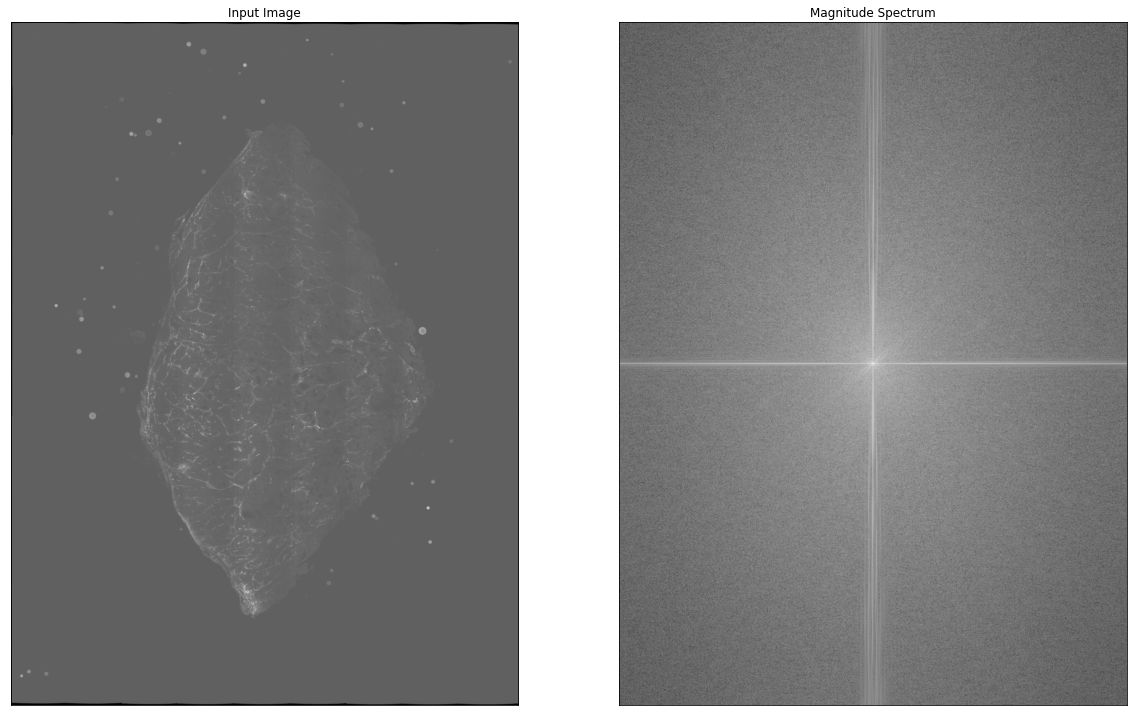

In [29]:
import cv2
file_names = ['20201216_PDX_STG143_SC_GFP_100x15um']
#file_names = ['20210104_PDX_AB580Sc_GFP_100x15um']

#https://www.kaggle.com/duynm619/remove-moire-in-pattern-duynm619

for file_name in file_names:
    in_file_name = "volumes/"+file_name+".mha"
    out_file_name = "processed/"+file_name+".mha"
    volume_itk = sitk.ReadImage(in_file_name, imageIO="MetaImageIO")
    volume = sitk.GetArrayFromImage(volume_itk)
    
    img = volume[0]
    
    dft = cv2.dft(np.float32(img),flags = cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)

    magnitude_spectrum = 20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))

    plt.subplot(121),plt.imshow(img, cmap = 'gray')
    plt.title('Input Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
    plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
    plt.show()


In [49]:
from scipy.ndimage import maximum_filter1d

maximum_filter1d([2, 8, 0, 4, 1, 9, 9, 0], size=3)

array([8, 8, 8, 4, 9, 9, 9, 9])